<a href="https://colab.research.google.com/github/emircanmurat/ai-image-processing-final-project/blob/main/cnn_cifar10_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. SETUP AND LIBRARIES
Importing essential libraries for AI model development (TensorFlow/Keras), data handling (NumPy), evaluation (Scikit-learn), and creating the testing interface (Gradio).

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, utils
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import gradio as gr

# 2. DATA PREPARATION AND PREPROCESSING

## 2.1 Filtering CIFAR-10 Dataset
The CIFAR-10 dataset is filtered to include only the **Airplane (index 0)** and **Automobile (index 1)** classes for binary classification.

In [2]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = datasets.cifar10.load_data()

TARGET_CLASSES = [0, 1]
CLASS_NAMES = ["airplane", "automobile"]

In [3]:
def filter_and_relabel(images, labels, targets):
    indices = np.where(np.isin(labels, targets))[0]

    filtered_images = images[indices]
    filtered_labels = labels[indices]

    new_labels = np.where(filtered_labels == targets[0], 0, 1)

    return filtered_images, new_labels.flatten()

x_train, y_train = filter_and_relabel(x_train_full, y_train_full, TARGET_CLASSES)
x_test, y_test = filter_and_relabel(x_test_full, y_test_full, TARGET_CLASSES)

print(f"Filtered Training Data Shape: {x_train.shape}")
print(f"Filtered Training Labels Shape: {y_train.shape}")

Filtered Training Data Shape: (10000, 32, 32, 3)
Filtered Training Labels Shape: (10000,)


## 2.2 Normalization and One-Hot Encoding
Pixel values are normalized from 0-255 to 0-1. Labels are converted to **One-Hot Encoding** format for use with `categorical_crossentropy` loss.

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_cat = utils.to_categorical(y_train, num_classes=2)
y_test_cat = utils.to_categorical(y_test, num_classes=2)

# 3. CNN MODEL DEFINITION AND TRAINING

## 3.1 Model Architecture
A **VGG-like CNN** architecture is defined. The output layer uses **2 neurons** with **Softmax** for binary classification.

In [12]:
model = models.Sequential()

model.add(layers.Input(shape=(32, 32, 3)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,164,258 (8.26 MB)

 Trainable params: 2,164,258 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Model Compilation and Training
The model is compiled using the **RMSprop** optimizer and trained for 10 epochs.

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Training started...")
history = model.fit(x_train, y_train_cat,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_test, y_test_cat))

model.save('airplane_automobile_cnn_model.keras')
print("\nModel saved as 'airplane_automobile_cnn_model.keras'.")

Training started...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6637 - loss: 0.6345 - val_accuracy: 0.7310 - val_loss: 0.5573
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8700 - loss: 0.3053 - val_accuracy: 0.8940 - val_loss: 0.2487
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9234 - loss: 0.1874 - val_accuracy: 0.9400 - val_loss: 0.1719
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9451 - loss: 0.1335 - val_accuracy: 0.9265 - val_loss: 0.1705
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9595 - loss: 0.1071 - val_accuracy: 0.9570 - val_loss: 0.1062
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9713 - loss: 0.0735 - val_accuracy: 0.9465 - val_loss: 0.1617
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9800 - loss: 0.0548 - val_accuracy: 0.9675 - val_loss: 0.1046
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9848 - loss: 0.04

# 4. EVALUATION AND REPORT OUTPUTS

## 4.1 Loss and Accuracy Curves
Visualizing the **Training/Validation Accuracy** and **Loss** across epochs.

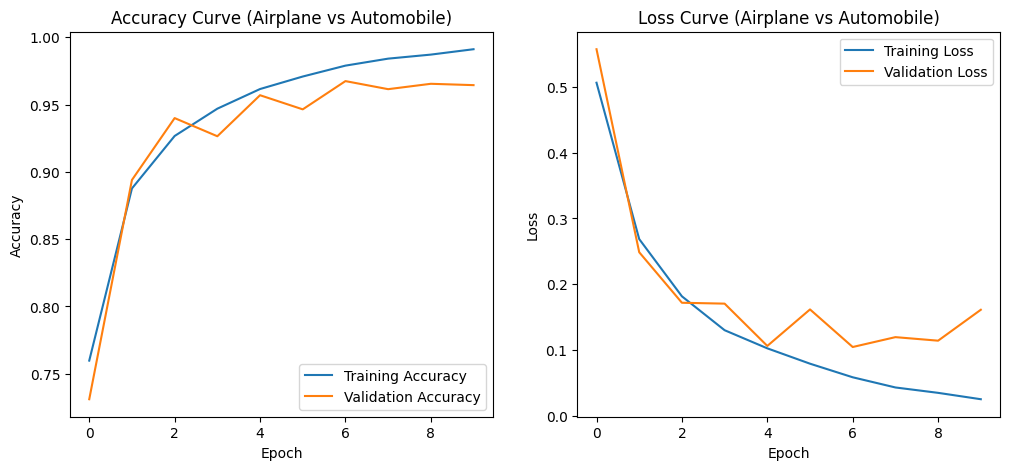

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (Airplane vs Automobile)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (Airplane vs Automobile)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## 4.2 Confusion Matrix
Generating and visualizing the **Confusion Matrix** to detail the model's predictions on the test set.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


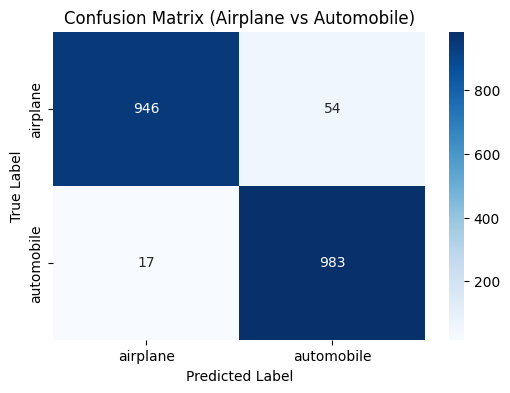

In [15]:
y_pred_probs = model.predict(x_test)

y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true_classes = y_test

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Airplane vs Automobile)')
plt.show()

# 5. TESTING INTERFACE

## Live Test Application
The **Gradio** library is used to create a simple web interface for live image testing.

In [16]:
def classify_image(input_image):
    img_array = np.array(input_image).astype('float32')

    img_resized = Image.fromarray(img_array.astype('uint8')).resize((32, 32))
    img_final = np.array(img_resized) / 255.0

    img_final = np.expand_dims(img_final, axis=0)

    predictions = model.predict(img_final)

    confidences = {CLASS_NAMES[i]: float(predictions[0][i]) for i in range(2)}

    return confidences

In [18]:
image_input = gr.Image(
    width=320,
    height=320,
    sources=["upload"],
    label="Upload Image to Test",
    type="pil"
)
label_output = gr.Label(num_top_classes=2)

iface = gr.Interface(fn=classify_image,
                     inputs=image_input,
                     outputs=label_output,
                     title="CNN Image Classification: Airplane vs Automobile",
                     description="Upload an image to classify it as either Airplane or Automobile.",
                     allow_flagging='never')

iface.launch(share=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0c73a5addd9468e5d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
